# Домашнее задание 2 (Линейная регрессия и KNN)

В каждом пункте от вас потребуется дописать код, необходимый для реализации задания, а так же ответить на ряд вопросов, проанализировав полученные результаты. Просьба отвечать на вопросы развёрнуто, аппелируя к полученным значениям или графикам, ответы вписывать в отдельную ячейку, выбрав для неё тип "Markdown". От полноты и качества ответов будет во многом зависеть ваша итоговая оценка.

Задание выполняется самостоятельно, плагиат будет стандартно наказываться лишением всех баллов за задание.

- Максимальная оценка за задание: 10 баллов.
- Дата выдачи: 28.2.2018
- Срок сдачи: 23:59 13.3.2018

In [1]:
import numpy as np
import sklearn.linear_model as lm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
%matplotlib inline

## Часть 1. Работа с модельными данными

В данном пункте требуется разобраться с базовыми техниками регрессионного анализа и сравнить их между собой на данных, чьи характеристики вы уже знаете (т.е., вам их придётся сгенерировать). Тем самым вы сами выявите все преимущества и недостатки используемых методов перед тем, как применять их на реальных данных, где полученные результаты, вообще говоря, без предварительных знаний могут плохо поддаваться объяснению.

Как вам уже известно из семинаров и лекций, существуют разные типы регрессии, которые определяют форму и свойства регрессионных кривых. Вы разберётесь с двумя основными способами их задания: трансформацией исходных данных $X$, а так же изменением оптимизируемого функционала $Q(w, b, \theta)$, где $w, b$ -- настраиваемые параметры линейной регрессии, $\theta$ -- т.н. гиперпараметры алгоритма построения регрессии, которые не настраиваются по обучающей выборке напрямую, поэтому всегда выделяются отдельно.

### 1.1. Генерация данных

От вас потребуется использовать уже знакомый по заданию 1 метод генерации данных для регрессии функций с линейным шумом:

In [2]:
def get_grid(n, D, x_min, x_max):
    """Генерирует сетку размера n^D x D"""
    xn = np.linspace(x_min, x_max, n)
    xn = np.meshgrid(*([xn]*D))
    return np.concatenate([xi.reshape((n**D, 1)) for xi in xn], axis=1)

def gen_data(n, D, x_min, x_max, f_target, f_noise):
    """Возвращает аргументы и зашумлённые значения для заданной функции
    
    Данная функция принимает на вход параметры выборки, которую требуется
    сгенерировать, а так же ссылки на функции, которые должны
    использоваться при генерации.
    
    n        -- размер одномерной выборки (совпадает с N при D=1)
    D        -- размерность выборки
    f_target -- целевая функция, которую будет аппроксимировать регрессия
    f_noise  -- функция, которая генерирует шум
    
    Возвращает сгенерированные данные и ответы на этих данных, а так же
    истинные значения функции
    
    X    -- выборка размера NxD, где N=n^D
    y    -- зашумлённые значения целевой функции
    y_gt -- истинные значения целевой функции"""
    X = get_grid(n, D, x_min, x_max)
    N = X.shape[0]
    y_gt = f_target(X)
    y = y_gt + f_noise(N)
    return X, y, y_gt

Пример генерации выборки для одномерной линейной функции с шумом $y = 2x + 3 + \epsilon$, где $x$ -- детерминированная переменная, $\epsilon$ -- шум  из нормального распределения с параметрами $\mu = 2, \sigma^2 = 4$, обозначение: $\epsilon \sim \mathcal{N}(2, 4)$.

In [3]:
def f_target(X):
    return 2*X + 3

def f_noise(N):
    """Обратите внимание, что функция random.normal принимает на вход
    стандартное отклонение, т.е. корень из диспресии"""
    return np.random.normal(loc=2, scale=2, size=N).reshape((N, 1))

X, y, y_gt = gen_data(10, 3, 0, 10, f_target, f_noise)

### 1.2. Знакомство с библиотеками

Для реализации регрессии вам потребуется пользоваться классами из библиотеки sklearn, в которой собраны практически все основные методы машинного обучения.

Базовым методом построения регрессии является линейная регрессия. Для её обучения предлагается использовать класс LinearRegression из модуля sklearn.linear_model

Оптимизируемый ей функционал записывается в следующем уже знакомом вам виде: $$ Q(w, b) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 \longrightarrow \min\limits_{w,b} $$

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

Так же вы познакомитесь с ещё двумя моделями регрессии: Ridge регрессия, которая призвана позволить регрессии работать лучше в случае, когда в признаках присутствовует линейная зависимость, и регрессия Lasso, которая дополнительно осуществляет отбор более информативных с её точки зрения признаков.

Функционал для Ridge регрессии:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D w_d^2  \longrightarrow \min\limits_{w,b} $$

Как видно, выбор оптимальных $w$ и $b$ будет существенно зависеть от выбора $\alpha$, но при этом сам параметр $\alpha$ в задаче оптимизации, решаемой по обучающей выборке, не участвует и участвовать не может, поэтому называется гиперпараметром данной модели.

Это означает, что Ridge регрессия (как и регрессия Lasso) уже не является решением out of the box, у самого алгоритма присутствуют так называемый гиперпараметр, от выбора которого напрямую будет зависеть качество решения вашей задачи. Такая ситуация крайне типична для машинного обучения. Для настройки параметров существует несколько подходов, и вы с ними познакомитесь позже. Пока что вам предлагается пользоваться регрессиями с параметрами по умолчанию.

Функционал для регрессии Lasso:

$$ Q(w, b, \alpha) = \sum_{i=1}^\ell (<x_i, w> +~ b - y_i)^2 + \frac{1}{\alpha} \sum_{d=1}^D |w_d|  \longrightarrow \min\limits_{w,b} $$

Описание класса Ridge: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

Описание класса Lasso: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

Ещё при построении регрессионных кривых сложного вида широко используется механизм трансформации признаков, когда вы некоторым способом делаете преобразование вашей выборки, генерируя по ней новую матрицу признаков размера NxD', где D' > D, и уже на новой выборке обучаете линейную регрессию.

Например, если в исходной матрице у вас всего два признака a и b, то, преобразовав их в [1, a, b, a^2, ab, b^2], вы сможете, применяя линейную регрессию на новых признаках, получать регрессионные кривые второго порядка.

Эти преобразования для любой степени итогового полинома выполняет класс PolynomialFeatures.

Описание класса: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn-preprocessing-polynomialfeatures

### 1.3. Эксперименты

Т.к. эксперименты мы будем проводить на искусственных данных, то для них мы всегда знаем значения незашумлённой функции, поэтому качество работы методов будем оценивать следующим функционалом усреднённой ошибки: $$\text{err}\ (y_{pred}, y_{gt}) = \frac{1}{N} \sum_{n=1}^N (y_{pred} - y_{gt})^2 $$ где $y_{pred}$ -- значения, предсказанные регрессией, $y_{gt}$ -- истинные значения функции (gt здесь сокращение от groundtruth, т.е. истинная незашумлённая функция).

#### Эксперимент 1

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, где $x$ принимает значения из равномерной сетки на [0, 3], а $\epsilon \sim \mathcal{N}(0, 1)$. Постройте график зависимости ошибки вашей линейной регрессии от размера выборки. При каком размере выборки регрессионная прямая перестаёт быть визуально отличимой от истинной? Постройте график с истинной прямой и обученной посредством регрессии.

Пример вызова класса, выполняющего линейную регрессию:

    LR = lm.LinearRegression()
    LR.fit(X_train, y_train)
    y_pred = LR.predict(X_train)

In [4]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = list(range(10, 1000, 10)) # список N, для которых требуется провести эксперимент

X, y, y_gt = gen_data(N_grid[-1], 1, 0, 3, f_target, f_noise) # Сгенерированные данные

Для каждого N в цикле добавьте в список err ошибку регрессии, которую вы обучили на случайных N элементах датасета. Ошибку требуется считать как MSE. Так же для каждого N сохраните обученные классы регрессии в список LRs (в примере вызова класс назван LR). predict делайте на всей выборке X.

In [5]:
from sklearn.model_selection import train_test_split
err = []
LRs = []
for N in N_grid:
    if N!=N_grid[-1]:
        X_train, _, y_train, _ = train_test_split(X, y, train_size=N, random_state=17, shuffle=True)
    else:
        X_train, y_train = X, y
    LR = lm.LinearRegression()
    LR.fit(X_train,y_train)
    y_prediction = LR.predict(X) 
    err.append(MSE(y_gt, y_prediction))
    LRs.append(LR)

C:\Users\lenovo-15\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Код для построения графиков:

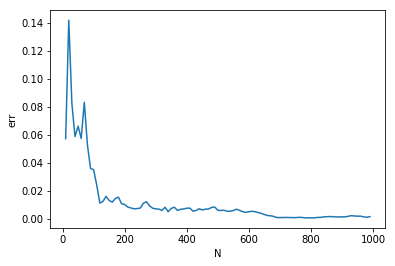

In [6]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

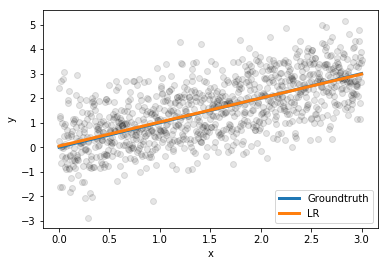

In [7]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = LRs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "LR"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Проделайте тоже самое для KNN при n_neighbors=3.

In [8]:
import sklearn.neighbors as neighbors
err = []
KNNs = []

for N in N_grid:
    if N!=N_grid[-1]:
        X_train, _, y_train, _ = train_test_split(X, y, train_size=N, random_state=17, shuffle=True)
    else:
        X_train, y_train = X, y
    KNN = neighbors.KNeighborsRegressor(n_neighbors = 3)
    KNN.fit(X_train,y_train)
    y_prediction = KNN.predict(X) 
    err.append(MSE(y_gt, y_prediction))
    KNNs.append(KNN)

C:\Users\lenovo-15\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


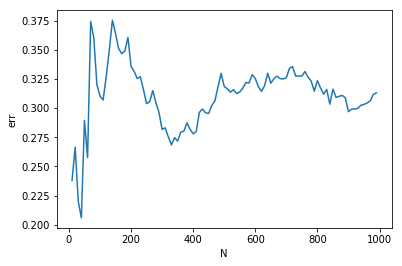

In [9]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

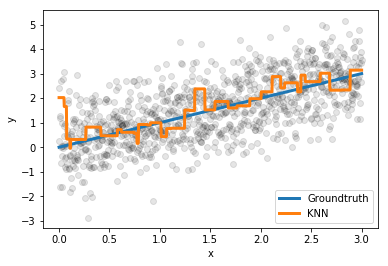

In [10]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Увеличте число соседей до 10 и проделайте тоже самое.

In [11]:
err = []
KNNs = []

for N in N_grid:
    if N!=N_grid[-1]:
        X_train, _, y_train, _ = train_test_split(X, y, train_size=N, random_state=17, shuffle=True)
    else:
        X_train, y_train = X, y
    KNN = neighbors.KNeighborsRegressor(n_neighbors = 10)
    KNN.fit(X_train,y_train)
    y_prediction = KNN.predict(X) 
    err.append(MSE(y_gt, y_prediction))
    KNNs.append(KNN)

C:\Users\lenovo-15\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


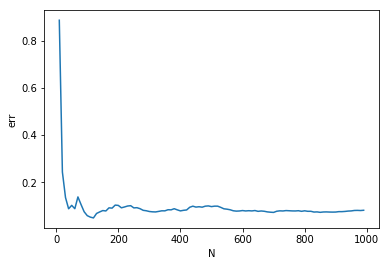

In [12]:
plt.plot(range(10, 1000, 10), err)
plt.xlabel("N")
plt.ylabel("err")
plt.show()

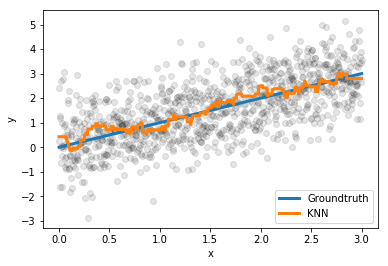

In [13]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred = KNNs[np.argmin(err)].predict(X)
plt.plot(X, y_pred, linewidth=3)
plt.legend(["Groundtruth", "KNN"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Какие выводы можно сделать?

**Ответ: **Когда у нас имеется простая линейная зависимость в целевой функции, линейная регрессия восстанавливает ее истинные значения гораздо лучше, чем KNN. KNN при учете 3 ближайших соседей имеет довольно высокую дисперсию и не очень хорошо приближает линейную функцию в силу того, что он на каждом отрезке дает константный прогноз (кусочно-постоянная фунцкия).

При учете 10 соседей их среднее находится немного ближе к значениям истинной функции, но, опять же, линейная регрессия и в этом случае дает меньшее значение ошибки. 

Для того, чтобы линейная регрессия лучше приближала исходную функцию, ей нужно достаточное количество элементов в обучающей выборке. При N>600 MSE в целом сходится к практически нулевому значению ошибки. Методу 10 ближайших соседей трбуется меньше элементов для сходимости ошибки, но при этом сам MSE выше. В случае 3 ближайших соседей ошибка растет с увеличением выборки, т.к алгоритм слишком сильно начинает подстраиваться под выбросы. 

#### Эксперимент 2

Изучим поведение регрессии с полиномиальными признаками. Для этого будем использовать класс PolynomialFeatures. Код вызова выглядит примерно так:

        import sklearn.preprocessing as pp
        Poly = pp.PolynomialFeatures(degree=d_new)
        X_new = Poly.fit_transform(X)

Сгенерируйте выборку для $y = log \frac{1}{3} x + \epsilon$, где $x$ принимает значения из равномерной сетки на  [1, 10], $\epsilon \sim \mathcal{N}(0, 1)$. Рассмотрите три случая: линейный, полиномиальные признаки степени 2 и 5. Для каждого постройте графики, аналогичные графику из эксперимента 1 и сравните их. Какой эффект вы наблюдаете? По какой причине он возникакет? Постройте график истинной кривой, и наилучших среди полиномиальных, которые вы исследовали. Какая из них лучше всего приближает данные и почему?

**Ответ: **При линейном приближении наблюдается явное недообучение - модель слишком простая, и может хорошо приближать только зависимости вида y = kx+b, поэтому в данном случае она не годится для приближения исходных данных. В случае с 5 признаками ситуация обратная - модель хорошо отображает истинную функцию на отрезке [1,10] - из-за большого числа полиномиальных признаков она старается "захватить" как можно больше точек на обучающей выборке, но при экстраполировании растет гораздо быстрее, чем исходная функция, ошибки при этом при увеличении X тоже значительно возрастает. 

Как итог - лучше всего данные приближает регрессию с полиномиальными признаками степени 2 - она достаточно сложная, чтобы приблизить логарифм, но при этом не слишком переобучается под обучающую выборку и хорошо экстраполируется.

In [14]:
import sklearn.preprocessing as pp

def f_target(X):
    return np.log(0.3*X)

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

N_grid = np.arange(10, 1000, 10)
X, y, y_gt = gen_data(N_grid[-1], 1, 1, 10, f_target, f_noise)

Аналогично предыдущему пункту, обучите в трёх циклах три разные регрессии, сохраняя полученные ошибки и классы в списки err_i и LRs_i. Перед обучением второй и третьих моделей вам требуется преобразовать признаки в полиномиальные, используя указанный в примере класс PolynomialFeatures. Сохраните полученные признаки степени 2 в переменную X_new_2, а признаки степени 5 в переменную X_new_3. Обучение соответственно происходит на выборках (X, y), (X_new_2, y), (X_new_3, y).

In [15]:
import sklearn.preprocessing as pp
err_1 = []
LRs_1 = []
for N in N_grid:
    if N!=N_grid[-1]:
        X_train, _, y_train, _ = train_test_split(X, y, train_size=N, random_state=17, shuffle=True)
    else:
        X_train, y_train = X, y
    LR = lm.LinearRegression()
    LR.fit(X_train,y_train)
    y_prediction = LR.predict(X) 
    err_1.append(MSE(y_gt, y_prediction))
    LRs_1.append(LR)
    
err_2 = []
LRs_2 = []
# Преобразуйте признаки в полиномиальные степени 2
for N in N_grid:
    Poly = pp.PolynomialFeatures(degree=2)
    X_new_2 = Poly.fit_transform(X)
    if N!=N_grid[-1]:
        X_train, _, y_train, _ = train_test_split(X_new_2, y, train_size=N, random_state=17, shuffle=True)
    else:
        X_train, y_train = X_new_2, y
    LR = lm.LinearRegression()
    LR.fit(X_train,y_train)
    y_prediction = LR.predict(X_new_2) 
    err_2.append(MSE(y_gt, y_prediction))
    LRs_2.append(LR)

err_3 = []
LRs_3 = []
# Преобразуйте признаки в полиномиальные степени 5
for N in N_grid:
    Poly = pp.PolynomialFeatures(degree=5)
    X_new_3 = Poly.fit_transform(X)
    if N!=N_grid[-1]:
        X_train, _, y_train, _ = train_test_split(X_new_3, y, train_size=N, random_state=17, shuffle=True)
    else:
        X_train, y_train = X_new_3, y
    LR = lm.LinearRegression()
    LR.fit(X_train,y_train)
    y_prediction = LR.predict(X_new_3) 
    err_3.append(MSE(y_gt, y_prediction))
    LRs_3.append(LR)

C:\Users\lenovo-15\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Код для построения всех графиков:

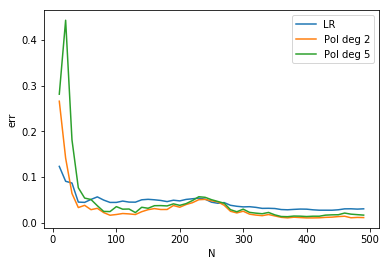

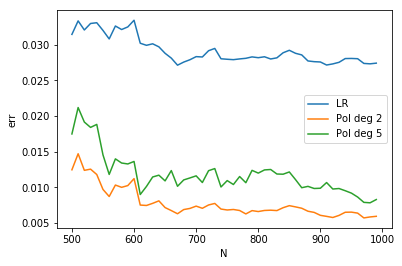

In [16]:
plt.plot(N_grid[:N_grid.size//2], err_1[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_2[:N_grid.size//2])
plt.plot(N_grid[:N_grid.size//2], err_3[:N_grid.size//2])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

plt.plot(N_grid[N_grid.size//2:], err_1[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_2[N_grid.size//2:])
plt.plot(N_grid[N_grid.size//2:], err_3[N_grid.size//2:])
plt.legend(["LR", "Pol deg 2", "Pol deg 5"])
plt.xlabel("N")
plt.ylabel("err")
plt.show()

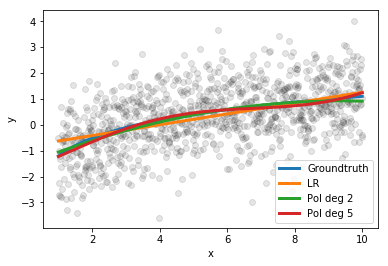

In [17]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_1 = LRs_1[np.argmin(err_1)].predict(X)
plt.plot(X, y_pred_1, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "LR", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

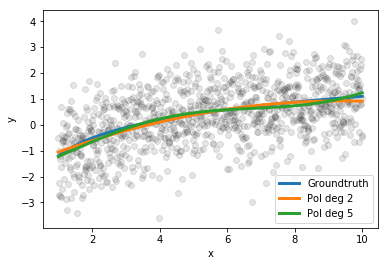

In [18]:
plt.scatter(X, y, c="black", alpha=0.1)
plt.plot(X, y_gt, linewidth=3)
y_pred_2 = LRs_2[np.argmin(err_2)].predict(X_new_2)
plt.plot(X, y_pred_2, linewidth=3)
y_pred_3 = LRs_3[np.argmin(err_3)].predict(X_new_3)
plt.plot(X, y_pred_3, linewidth = 3)
plt.legend(["Groundtruth", "Pol deg 2", "Pol deg 5"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

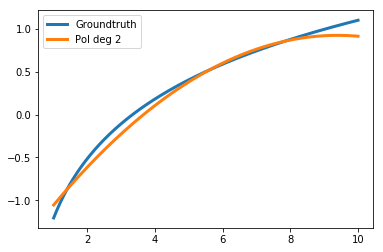

In [19]:
plt.plot(X, y_gt, linewidth=3)
plt.plot(X, y_pred_2, linewidth=3)
plt.legend(["Groundtruth", "Pol deg 2"])

#### Эксперимент 3

Рассмотрим данные с искусственно внесёнными в них линейными зависимостями. Для наглядности рассмотрим регрессию, которая фактически зависит лишь от одной переменной, но в сгенерированный набор данных внесём ещё несколько признаков, которые будут слабо коррелировать с первым.

Сгенерируйте зашумлённую выборку для функции $y = x + \epsilon$, $x$ принимает значения из равномерной сетки на [0, 3], $\epsilon \sim \mathcal{N}(0, 1)$. Добавьте в качестве второго признака $x_2 = 2x + \delta$, где $\delta \sim \mathcal{N}(0, 0.01)$, а в качестве третьего $x_3 = x_1 + x_2 + \nu$, где $\nu \sim \mathcal{N}(0, 0.25)$. Постройте графики истинной функции, линейной регрессии и Ridge регрессии, в зависимости от первого столбца данных (при этом саму регрессию нужно обучать по всем трём признакам). Какой эффект вы наблюдаете? Какая регрессия работает лучше и почему? (Для ответа на этот вопрос можете, например, сравнить веса признаков, полученные в случае обычной и Ridge линейных регрессий, параметр класса: coef_)

**Ответ:** Видно, что коллинеарные признаки создают очень большой шум и предсказание выходит довольно неточным. Обе регрессии работают примерно одинаково, так как L2-регуляризация ограничивает L2-норму вектора весов при линейной регрессии, а в данном случае эти веса вышли не особо большими, несмотря на коллинеарность, поэтому Ridge регрессия ситуацию не спасла.

Пример вызова класса, выполняющего Ridge регрессию:

    Ridge = lm.Ridge()
    Ridge.fit(X_train, y_train)
    y_pred = Ridge.predict(X_train)

In [20]:
def f_target(X):
    return X

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация данных"""
N = 1000
X, y, y_gt = gen_data(N, 1, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x2 = 2*X + delta
x3 = X + x2 + nu
X = np.concatenate([X, x2, x3], axis=1)

Аналогично предыдущим пунктам, обучите обычную и Ridge линейные регрессии на выборке (X, y) и получите предсказания для той и другой модели. Сохраните предсказания в переменные y_pred_LR и y_pred_Ridge.

In [21]:
LR = lm.LinearRegression()
LR.fit(X,y)
y_pred_LR = LR.predict(X) 
    
Ridge = lm.Ridge()
Ridge.fit(X, y)
y_pred_Ridge = Ridge.predict(X)

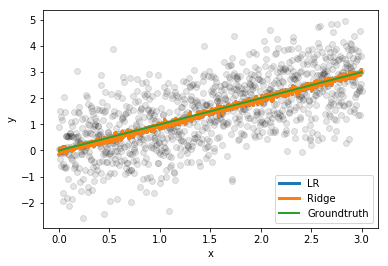

In [22]:
plt.scatter(X[:,0], y, c="black", alpha=0.1)
plt.plot(X[:,0], y_pred_LR, linewidth=3)
plt.plot(X[:,0], y_pred_Ridge, linewidth=3)
plt.plot(X[:,0], y_gt, linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=4)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

График для разности предсказанных ответов и истинных:

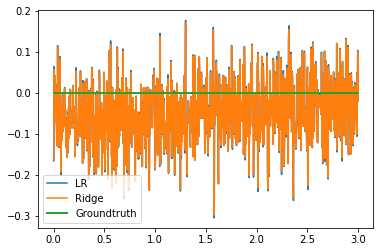

In [23]:
plt.plot(X[:,0], y_pred_LR - y_gt)
plt.plot(X[:,0], y_pred_Ridge - y_gt)
plt.plot(X[:,0], np.zeros(N), linewidth=2)
plt.legend(["LR", "Ridge", "Groundtruth"], loc=3)
plt.show()

In [24]:
print(np.sum((y_pred_LR - y_gt)**2))
print(np.sum((y_pred_Ridge - y_gt)**2))

7.73788231053
7.48750161382


In [25]:
print(LR.coef_)
print(Ridge.coef_)

[[-0.04974143  0.38085833  0.10085429]]
[[ 0.0119501   0.34839483  0.1019125 ]]


#### Эксперимент 4

Рассмотрим последний предложенный вам вид регрессии: Lasso. Основным его свойством является возможность отбора признаков, в чём вам и придётся убедится. Сгенеририруйте двумерную выборку для зашумлённой функции $y = x_1 + x_2 + \epsilon$, $x_1$ и $x_2$ образуют равномерную линейную сетку на квадрате [0,1]x[0,1], $\epsilon \sim \mathcal{N}(0, 1)$, и добавьте в неё два линейно зависимых признака с шумом: 

$$x_3 = 2x_1 + \delta, \quad \delta \sim \mathcal{N}(0, 0.01)$$, 
$$x_4 = 0.5x_1 + x_2 + \nu, \quad \nu \sim \mathcal{N}(0, 0.25)$$ 

После этого запустите на данной выборке регрессию Ridge и Lasso, сравните получаемые веса для признаков. Какие эффекты вы наблюдаете? В чём различие? Как именно в Lasso производится явное уменьшение размерности данных?

**Ответ:** В Lasso регрессии веса первых двух признаков занулились, в то время как при гребневой регрессии ни один признак не равен нулю. Уменьшение размерности происходит с помощью зануления весов незначимых при определенном коэффициенте регуляризации признаков. В случае L1-регуляризации производная чаще всего проходит по углу фигуры, которая ограничивает сумму модулей весов модели, и этот угол находится на какой-то из координатных осей, таким образом, один из признаков становится равным нулю.

Пример вызова класса, выполняющего регрессию Lasso:

    Lasso = lm.Lasso()
    Lasso.fit(X_train, y_train)
    y_pred = Lasso.predict(X_train)

In [26]:
def f_target(X):
    return np.sum(X, axis=1).reshape((X.shape[0], 1))

def f_noise(N):
    return np.random.normal(loc=0, scale=1, size=N).reshape((N, 1))

"""Генерация выборки"""
n = 30
D = 2
N = n**D
X, y, y_gt = gen_data(n, D, 0, 3, f_target, f_noise)
delta = np.random.normal(loc=0, scale=0.1, size=N).reshape((N, 1))
nu = np.random.normal(loc=0, scale=0.5, size=N).reshape((N, 1))
x3 = 2*X[:,0].reshape((N, 1)) + delta
x4 = 0.5*X[:,0].reshape((N, 1)) + X[:,1].reshape((N, 1)) + nu
X = np.concatenate([X, x3, x4], axis=1)

Обучите на выборке регрессии Lasso и Ridge на выборке (X, y), используя вызовы соответствующих классов.

In [27]:
from sklearn.linear_model import Lasso

Lasso = lm.Lasso()
Lasso.fit(X,y) 
    
Ridge = lm.Ridge()
Ridge.fit(X, y)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [28]:
print(Lasso.coef_)
print(Ridge.coef_)

[ 0.          0.          0.16948705  0.06169249]
[[ 1.01300449  0.9006659  -0.02790402  0.0759017 ]]


## Часть 2. Задача с реальными данными

В данной части вам предлагается, используя изученные методы построения регрессии, проанализировать реальный датасет.

Будем исследовать данные по преступности в разных штатах США. От вас потребуется по большому количеству признаков, связанных с социальными и экономическими показателями, восстановить целевую переменную: среднее число преступлений на 100 тысяч человек. С полным описанием датасета можно ознакомиться здесь: https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

In [29]:
import pandas as pd

In [30]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
                   na_values="?", header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


Исходя из описания датасета, первые 5 колонок не являются информативными признаками, убираем их.

In [31]:
data = data.iloc[:,5:]

#### 1. Вычислите и визуализируйте попарную корреляцию пирсона между всеми признаками.  Как коррелирующие признаки будут влиять на обучение линейной регрессии. Какие выводы можно сделать?

Коррелирующие признаки ведут к тому, что у нас будет проявляться эффект мультиколлинеарности. Матрица $X^T * X$ будет либо вырожденной, либо ее детерминант будет близок к нулю. (Псевдо)обращение такой матрицы приведет к тому, что само оценивание весов модели будет не очень точным, при этом веса у коллинеарных признаков, скорее всего, будут огромными.

Это приведет к тому, что модель будет очень плохо обобщаться и давать плохие результаты на любой выборке, кроме обучающей. В данном датасете по heatmap'у видно много коррелирующих признаков, если от них не избавиться, модель будет очень сильно переобучаться под обучающую выборку и даст плохие результаты при предсказании новых значений.

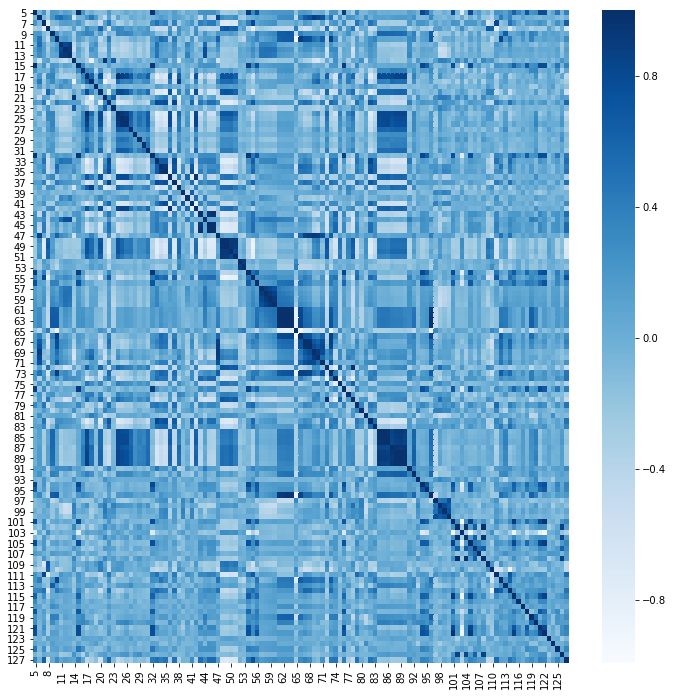

In [32]:
plt.figure(figsize = (12,12))
corr_matrix = data.corr(method='pearson')
sns.heatmap(corr_matrix, cmap='Blues')

#### 2. Найдите признаки у которых корреляция с предсказваемым значением максимальна и минимальна. Изобразите на графиках зависимость найденных признаков от предсказываемого значения.

In [33]:
corr_min_ind = data.drop(127, axis=1).corrwith(data[127]).argmin()
corr_max_ind = data.drop(127, axis=1).corrwith(data[127]).argmax()

In [34]:
data[corr_max_ind].corr(data[127])

0.73795654985866332

Text(0,0.5,'Variable with max corr: 55')

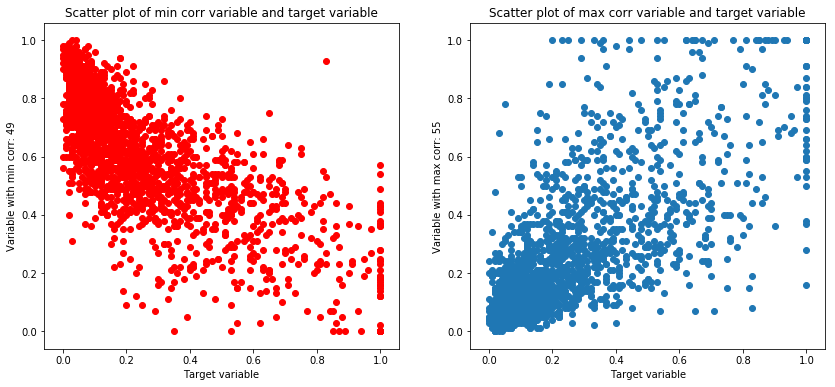

In [35]:
plt.figure(figsize = (14,6))
plt.subplot(121)
plt.scatter(data[127], data[corr_min_ind], c='Red')
plt.title('Scatter plot of min corr variable and target variable')
plt.xlabel('Target variable')
plt.ylabel('Variable with min corr: ' + str(corr_min_ind))
plt.subplot(122)
plt.title('Scatter plot of max corr variable and target variable')
plt.scatter(data[127], data[corr_max_ind])
plt.xlabel('Target variable')
plt.ylabel('Variable with max corr: ' + str(corr_max_ind))

#### 3. Постройте гистограмму распределения предсказываемого значения.

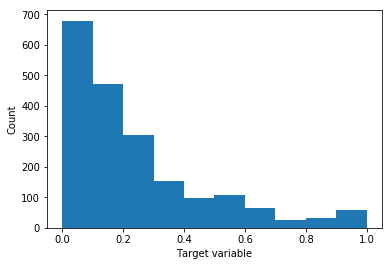

In [36]:
plt.hist(data[127]);
plt.xlabel('Target variable');
plt.ylabel('Count');

Как видно из заголовка датасета, в нём присутствует много пропущенных значений. Рассмотренные нами алгоритмы регрессии не содержат в себе методов обработки пропущенных значений, поэтому нам нужно избавиться от них на этапе предобработки данных.


#### 4. Замените все пропущенные значения на средние по соответствующим признакам. Сохраните результат в переменную data.

In [37]:
data.fillna(data.mean(), inplace=True);

Разделим данные на три выборки: по одной мы будем обучать регрессию, по второй -- гиперпараметры, по третьей -- тестировать качество (Три части необходимы для бонусной части) В базовой части GridSearchCV необходимо делать на (X_train_new, y_train_new)

In [38]:
data = data.reindex(np.random.permutation(data.index))
data_train, data_validate, data_test = np.array_split(data, 3)

Учтём, что целевая переменная -- это последний столбец данных:

In [39]:
X_train = data_train.iloc[:,:-1]
y_train = data_train.iloc[:,-1]
X_validate = data_validate.iloc[:,:-1]
y_validate = data_validate.iloc[:,-1]
X_test = data_test.iloc[:,:-1]
y_test = data_test.iloc[:,-1]

In [40]:
X_train_new = np.concatenate([X_train, X_validate], axis=0)
y_train_new = np.concatenate([y_train, y_validate], axis=0)

#### 5. Обучите обычную линейную регрессию на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

Качество оценивайте, как среднеквадратичное отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

In [41]:
LR = lm.LinearRegression()
LR.fit(X_train_new, y_train_new)
y_pred = LR.predict(X_test)
print(MSE(y_test, y_pred))

0.0185885872064


#### 6. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения гиперпараметра alpha для  регрессий Ridge и Lasso

In [42]:
from sklearn.model_selection import GridSearchCV
param_grid = {'alpha' : np.arange(0.001, 10, 0.1)}

Lasso = lm.Lasso()
Ridge = lm.Ridge()

grid_lasso = GridSearchCV(Lasso, param_grid)
grid_ridge = GridSearchCV(Ridge, param_grid)

grid_lasso.fit(X_train_new, y_train_new);
grid_ridge.fit(X_train_new, y_train_new);

In [43]:
print('Lasso:', grid_lasso.best_params_)
print('Ridge:', grid_ridge.best_params_)

Lasso: {'alpha': 0.001}
Ridge: {'alpha': 9.9009999999999998}


Рассмотрите значения полученных весов для регрессии в с лучшим alpha для Ridge и Lasso. В чём их существенная разница? Какие выводы вы можете сделать о структуре данных по регрессионным весам?

Многие веса в Lasso занулились даже при слабой регуляризации ($\alpha = 0.001$). Это означает, что в данных многие признаки выражаются друг через друга, то есть они линейно зависимы либо же не особо значимы. Lasso регрессия в данном случае хорошо справляется с мультиколлинеарностью и отбором признаков. 

In [44]:
new_features = abs(grid_lasso.best_estimator_.coef_) > 1e-6 # Для бонусного задания №2
grid_lasso.best_estimator_.coef_

array([ 0.        ,  0.        ,  0.13079227, -0.08571677,  0.        ,
        0.        , -0.        , -0.        , -0.        ,  0.        ,
        0.        ,  0.03722571,  0.        , -0.00445541, -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        ,  0.01807019,
        0.01220072,  0.        ,  0.        , -0.        ,  0.        ,
        0.        , -0.        ,  0.        , -0.        , -0.        ,
       -0.01162582,  0.        , -0.        ,  0.14369606, -0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.19453846,
       -0.05496524, -0.        , -0.        , -0.07284558,  0.        ,
        0.1902874 ,  0.        , -0.        , -0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.11718169,  0.  

В случае с Ridge регрессией, напротив, понадобился большой коэффициент регуляризации ($\alpha = 5$), чтобы побороть эффект мультиколлинеарности. Тут, в отличие от Lasso регресии, веса не занулились, но стали меньше изначальных (без регуляризации).

In [45]:
grid_ridge.best_estimator_.coef_

array([ 0.01672672,  0.0156156 ,  0.13576757, -0.08879148, -0.00803304,
        0.00559236, -0.01532581, -0.03311904, -0.01241566,  0.01389297,
        0.01044698,  0.04148316,  0.01025665, -0.03705558,  0.00789164,
       -0.05331065,  0.02269259,  0.01523999, -0.04445307,  0.00531564,
       -0.01350025, -0.01674302, -0.01193017, -0.01728191,  0.04056152,
        0.02992536,  0.03076624,  0.01345582, -0.03593848, -0.03068148,
        0.0277707 , -0.00426242, -0.00312767,  0.01521744, -0.0291394 ,
       -0.02513236,  0.02678356, -0.01545049,  0.06784431,  0.01915769,
        0.00231427,  0.02532841,  0.01294997, -0.05728897, -0.08637965,
       -0.08191241, -0.0254735 , -0.02859547, -0.05340727, -0.00111733,
        0.13260498, -0.00979563,  0.00290989, -0.01099125,  0.00111102,
        0.01461604, -0.00525866,  0.0048143 ,  0.02095052,  0.01421631,
        0.00952429, -0.03559172,  0.00511716,  0.00122239,  0.02484946,
       -0.01592097,  0.00119365, -0.03515639,  0.04867152,  0.02

Исходя из весов регрессии Lasso, отберите наиболее релевантные признаки и обучите две лучшие регрессионные модели только на них. Насколько сильно при этом изменилась средняя ошибка? Что это говорит о структуре данных? 

**Ответ: **Средняя ошибка немного снизилась - на 0.001 в случае Lasso и на 0.002 в случае Ridge. Это говорит о том, что многие признаки в данных являются избыточными/зашумляющими либо коллинеарными. Таким образом, они только лишь мешают простой линейной регрессии восстановить истинную зависимость. Регуляризация помогает справится с этой проблемой.

In [46]:
X_train_new_filtered = X_train_new[:,grid_lasso.best_estimator_.coef_!=0] 
                                                                        #выбираем те коэффициенты Lasso, которые не равны нулю.
X_test_filtered = X_test.values[:,grid_lasso.best_estimator_.coef_!=0] 
best_Lasso = grid_lasso.best_estimator_
best_Ridge = grid_ridge.best_estimator_

In [47]:
best_Lasso.fit(X_train_new_filtered, y_train_new)
best_Ridge.fit(X_train_new_filtered, y_train_new)
y_pred_Lasso = best_Lasso.predict(X_test_filtered)
y_pred_Ridge = best_Ridge.predict(X_test_filtered)
print('Lasso error: ', MSE(y_test, y_pred_Lasso))
print('Ridge error: ', MSE(y_test, y_pred_Ridge))

Lasso error:  0.0175737307897
Ridge error:  0.0176713099954


#### 7. Обучите KNN на выборке (X_train_new, y_train_new).  Оцените качество предсказания на данных X_test.

In [48]:
KNN = neighbors.KNeighborsRegressor()
KNN.fit(X_train_new,y_train_new)
y_prediction = KNN.predict(X_test) 
print(MSE(y_test, y_prediction))

0.0215013313253


#### 8. Используя sklearn.model_selection.GridSearchCV(), подберите оптимальные значения параметров n_neighbors и p при выборе  metric='minkowski'

In [49]:
KNN = neighbors.KNeighborsRegressor(metric='minkowski')
param_grid = {'n_neighbors' : range(1,8), 'p': range(1,6)}
grid_KNN = GridSearchCV(KNN, param_grid, n_jobs=-1)
grid_KNN.fit(X_train_new, y_train_new)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': range(1, 8), 'p': range(1, 6)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [50]:
y_prediction = grid_KNN.best_estimator_.predict(X_test) 
print(MSE(y_test, y_prediction))

0.0206977993607


С помощью какого алгоритма удалось достичь лучшего качества?

**Ответ: **Ridge регрессия и Lasso справились лучше всех. Разница между качеством работы этих двух видов регрессии практически незаметна.

Напишите отчёт по исследованному вами датасету. Какими он обладает ключевыми свойствами? Какие методы вам пришлось использовать, чтобы его исследовать? Что вы можете сказать об информативности используемых в нём признаков? Какой из опробованных методов вы бы предпочли использовать на нём и почему?

**Ответ:** В данном датасете есть очень много признаков, коллинеарных между собой. Помимо этого, судя по результатам запущенных ранее моделей, можно предположить, что в данных много зашумляющих признаков, которые никак не влияют на предсказываемую величину. Таким образом, многие признаки неинформативны и просто мешают простым моделям восстановить истинную зависимость.

На данных я бы предпочел использовать Lasso регрессию, т.к она проводит отбор только информативных признаков и уменьшает среднеквадратичную ошибку. Помимо этого, результаты такой регрессии в теории будет проще интерпретировать - гораздо проще объяснить на словах влияние 10 признаков, чем 110 признаков.

### Бонусная часть

За выполнение указанного ниже задания вам могут быть начислены дополнительные баллы свыше максимальных 10.

##### Реализуйте свмостоятельно функцию, которая будет перебирать значения гиперпараметра по линейной сетке 

Процесс обучения модели будет состоять из двух этапов.

Сначала для каждого значения гиперпараметра из заранее заданной сетки мы обучим регрессию на выборке (X_train, y_train) и проверим качество её работы на выборке (X_validate, y_validate). Сохранив полученные значения, среди всех перебранных значений гиперпараметра выберем такое, на котором достигается наименьшая ошибка на выборке (X_validate, y_validate).

После этого мы фиксируем значение гиперпараметра, и обучаем итоговый алгоритм на выборке, полученной объединением из X_train и X_validate . Тем самым мы сможем добиться лучшей настройки параметров регресси.

В конце концов, для тестирования качества работы нашей модели, мы проверяем её на тестовой выборке (X_test, y_test). Ошибка на этой выборке позволяет нам судить об обобщающей способности нашей модели, т.к. она не участвовала ни в одном этапе обучения. Обобщающая способность -- оценка того, насколько хорошо модель регрессии будет работать на новых данных.

In [51]:
#alpha_grid - массив перебираемых значений гиперпараметра
#alpha - найденное оптимальное значение гиперпараметра 
#err - массив среднеквадратичных отклонений для каждого из alpha_grid
def optimizer(X_train, y_train, X_validate, y_validate, 
              alpha_min, alpha_max, RegressionClass):
    err = []
    alpha_grid = np.linspace(alpha_min, alpha_max, 100)
    for alpha in alpha_grid:
        model = RegressionClass(alpha = alpha)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_validate)
        error = MSE(y_validate, y_pred)
        err.append(error)
    alpha = alpha_grid[np.argmin(np.array(err))]
    return alpha, err, alpha_grid

Пример вызова:
        
        alpha, err, alpha_grid = optimiser(X_train, y_train, 
                                           X_validate, y_validate,
                                           alpha_min, alpha_max,
                                           lm.Ridge)

От вас требуется применить линейную регрессию, а также Ridge и Lasso регрессию, получив оптимальные значения для alpha при помощи функции optimizer, и сравнить полученные среднеквадратичные отклонения ваших предсказаний на тестовой выборке от истинных значений: $$\text{err}\ (y^{pred}, y^{test}) = \frac{1}{N} \sum_{n=1}^N (y^{pred}_n - y^{test}_n)^2$$

Для того чтобы понять, какие значения alpha для регрессий Ridge и Lasso являются оптимальными, вам нужно подобрать параметры alpha_min и alpha_max так, чтобы на графиках зависимости ошибки err от alpha был виден отчётливый минимум. Код для построения графиков указан ниже.

Обучите регрессии на выборке (X_train_new, y_train_new)
Какая из трёх регрессий работает лучше? Какая хуже? Почему?

Сделайте вызов функции optimizer для Ridge регрессии на выборках (X_train, y_train), (X_validate, y_validate), воспользовавшись примером её запуска. Получите оптимальное alpha, подобрав параметры alpha_min, alpha_max, как указано в задании. Обучите регрессию на выборке (X_train_new, y_train_new) с полученным параметром alpha, который передаётся при инициализации класса, например:

    lm.Ridge(alpha=my_alpha)
    
и сохраните ответы на тестовой выборке X_test в переменную y_pred

In [52]:
alpha, err, alpha_grid = optimizer(X_train, y_train, 
                                       X_validate, y_validate,
                                       0.1, 50,
                                       lm.Ridge)
Ridge = lm.Ridge(alpha=alpha)
Ridge.fit(X_train_new, y_train_new)
y_pred = Ridge.predict(X_test)
print(np.mean((y_pred - y_test)**2))
print(data.mean().iloc[-1]) #не знаю, зачем тут стоит среднее целевой переменной, но я исправил,
                            #т.к исходный код выдавал ошибку с DataFrame

0.017332919474543133
0.23797893681


Код для построения графиков ошибки на валидационной выборке в зависимости от alpha:

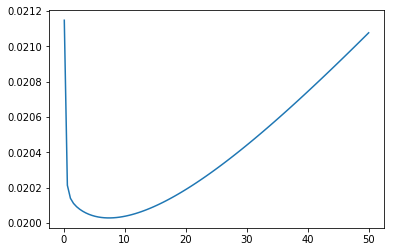

In [53]:
plt.plot(alpha_grid, err)
plt.show()

Аналогично части задания для регресии Ridge, сделайте вызов функции optimizer для регрессии Lasso, обучите её с оптимальным alpha на выборке (X_train_new, y_train_new) и сохраните предсказания для X_test в y_pred

In [60]:
alpha, err, alpha_grid = optimizer(X_train, y_train, 
                                       X_validate, y_validate,
                                       0.0005, 0.1,
                                       lm.Lasso)
Lasso = lm.Lasso(alpha=alpha)
Lasso.fit(X_train_new, y_train_new)
y_pred = Lasso.predict(X_test)

print(np.mean((y_pred - y_test)**2))
#print(data.mean().iloc[-1])

0.017448151240044747


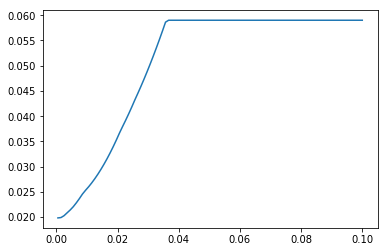

In [61]:
plt.plot(alpha_grid, err)
plt.show()

#### Бонусная часть 2

Ещё одним способом построения новых признаков по выборке (помимо полиномиальных преобразований) являются так называемые приближения ядер RBF (Radial Basis Function Kernel Approximations). Данный метод используется широко и везде, так как позволяет проводить в данных регрессионные кривые, вообще говоря, практически произвольной сложности. Суть его заключается в том, что он производит некоторое нелинейное преобразование признаков, которое призвано приближать абстрактное пространство бесконечной размерности. Если размерность пространства бесконечна, то в нём можно посредством линейной регрессии провести произвольную разделяющую поверхность -- в этом суть мощности данного метода.

У метода существуют два настраиваемых параметра: gamma и n_components. Для объяснения значения первого параметра потребуется подключать достаточно сложную линейную алгебру или привлекать понятие ядровой функции, что мы делать сейчас не будем. Смысл второго параметра -- количество получаемых признаков. Т.к. пространство, которое мы пытаемся приблизить, бесконечной размерности, то, вообще говоря, в n_components можно поставить любое число. Чем больше оно будет, тем лучше наши новые данные будут приближать абстрактное пространство. Данные параметры в любом случае следует лишь перебирать по сетке и выбирать те, на которых меньше всего ошибка. Для того чтобы перебор не оказался слишком большим, положим n_components равным размеру выборки, и будем настраивать лишь gamma. В предложенной задаче это не критично.

Ниже приведён код, который уже знакомым вам по функции optimizer образом переберёт по сетке гиперпараметры используемых методов: параметр gamma для RBF, и параметр alpha для Ridge регрессии. Перебор будем осуществлять по всем возможным комбинациям gamma и alpha, выбрав комбинацию с наименьшей ошибкой на валидационной выборке. Обратите внимание, что обучаться мы будем именно по подвыборке признаков, полученных вами в предыдущем задании, т.е. исключая из данных большую часть данных. Интересно, что из этого выйдет?

обозначим new_features - номера признаков отобранных с помощью Lasso

In [56]:
X_train_shrinked = X_train.iloc[:,new_features]
X_validate_shrinked = X_validate.iloc[:,new_features]
X_test_shrinked = X_test.iloc[:,new_features]
X_train_new_shrinked = X_train_new[:,new_features]

In [57]:
from sklearn import kernel_approximation as ka

alpha_grid = np.linspace(0.001, 1, 10)
gamma_grid = np.linspace(0.001, 1, 10)

min_err = +np.inf
for alpha in alpha_grid:
    for gamma in gamma_grid:
        RBF = ka.RBFSampler(gamma=gamma, n_components=X_train.shape[0])
        X_train_rbf = RBF.fit_transform(X_train_shrinked)
        X_validate_rbf = RBF.transform(X_validate_shrinked)
        Ridge = lm.Ridge(alpha=alpha)
        Ridge.fit(X_train_rbf, y_train)
        y_pred = Ridge.predict(X_validate_rbf)
        err = np.mean((y_pred - y_validate)**2)
        if err < min_err:
            min_err = err
            alpha_best = alpha
            gamma_best = gamma

Выполнив код выше, вы получили две переменные alpha_best и gamma_best с оптимальными значениями гиперпараметров. От вас потребуется обучить на выборке (X_train_new_shrinked, y_train_new) преобразование RBF с параметром gamma_best (параметр n_components заполните так, как указано в примере ниже), а потом обучить на полученных признаках Ridge регрессию с полученным alpha_best и сравнить получившуюся ошибку с ошибой всех предыдущих методов. Какой эффект вы заметили?

Для обучения преобразования RBF вам потребуется сначала преобразовать обучающую выборку с помощью метода fit_transform (в вашем случае X_train_new_shrinked), а потом применить обученное преобразование к тестовой выборке (X_test_shrinked)

    RBF = ka.RBFSampler(gamma=gamma_best, n_components=X_train_new.shape[0])
    X_train = RBF.fit_transform(X_train)
    X_test = RBF.transform(X_test)

Ниже запишите вызов класса RBF, получите новые признаки для обучающей и тестовой выборки. Постройте Ridge регрессию по выборке (X_train_new_shrinked, y_train_new), найде предсказания для тестовой X_test_shrinked, поместите их в переменную y_pred.

In [58]:
RBF = ka.RBFSampler(gamma=gamma_best, n_components=X_train_new.shape[0])
X_train_new_shrinked = RBF.fit_transform(X_train_new_shrinked, y_train_new)
X_test_shrinked = RBF.transform(X_test_shrinked)

Ridge = lm.Ridge(alpha=alpha_best)
Ridge.fit(X_train_new_shrinked, y_train_new)
y_pred = Ridge.predict(X_test_shrinked)
print(np.mean((y_pred - y_test)**2))
#print(data.mean()[-1])

0.017856503184594794
